In [1]:
import pandas as pd
import numpy as np
import googlemaps
from datetime import datetime
import acquire_r
from env import google_key
from googlemaps import convert
import wrangle_zillow_r
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
#df = acquire_r.get_zillow_data()
# df1 = df1.dropna()

In [3]:
#df.to_csv('zillow.csv')

In [4]:
zillow = pd.read_csv('zillow.csv')

In [5]:
single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
zillow = zillow[zillow.propertylandusetypeid.isin(single_use)]

In [6]:
zillow = zillow[(zillow.bedroomcnt > 0) & (zillow.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())]

NameError: name 'df' is not defined

In [7]:
zillow.unitcnt.value_counts()

1.0    45403
2.0       34
3.0        3
6.0        1
Name: unitcnt, dtype: int64

In [8]:
zillow.fips.value_counts()

6037.0    45672
6059.0    20405
6111.0     5783
Name: fips, dtype: int64

In [9]:
zillow['county'] = np.where(zillow.fips == 6037, 'Los_Angeles',
                            np.where(zillow.fips == 6059, 'Orange', 'Ventura'))

In [10]:
zillow['regionidzip'] = zillow['regionidzip'].replace(399675, 99675)

In [11]:
zillow = wrangle_zillow_r.zillow_impute_knn(zillow)

In [12]:
zillow = wrangle_zillow_r.add_zip_income(zillow)

In [13]:
def fill_nulls_with_zero(df, col_names):
    for col in col_names:
        df[col] = df[col].fillna(0)
    return df

In [14]:
# Test function
null_cols = ['airconditioningtypeid', 'basementsqft', 'decktypeid',
             'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
             'hashottuborspa', 'lotsizesquarefeet', 'poolcnt',
             'poolsizesum', 'taxdelinquencyyear']

zillow = fill_nulls_with_zero(zillow, null_cols)

In [15]:
# Heatingorsystemtypeid - None type is 13
# Assume number of stories is 1
# Assume unitcnt is 1

def handle_other_nulls(df):
    df.heatingorsystemtypeid.fillna(13, inplace=True)
    df.numberofstories.fillna(1, inplace=True)
    df.unitcnt.fillna(1, inplace=True)
    return df

In [16]:
zillow = handle_other_nulls(zillow)

In [17]:
zillow.isnull().sum().sort_values(ascending = False)

buildingclasstypeid     74234
buildingclassdesc       74234
finishedsquarefeet13    74232
finishedsquarefeet15    74223
storydesc               74187
                        ...  
poolsizesum                 0
poolcnt                     0
lotsizesquarefeet           0
longitude                   0
Unnamed: 0                  0
Length: 73, dtype: int64

In [18]:
zillow = wrangle_zillow.remove_columns(zillow, 
                                       ['parcelid',
                                        'architecturalstyletypeid',
                                        'buildingclasstypeid',
                                        'finishedsquarefeet13',
                                        'finishedsquarefeet15',
                                        'finishedsquarefeet50',
                                        'finishedsquarefeet6',
                                        'finishedfloor1squarefeet',
                                        'pooltypeid10',
                                        'pooltypeid2',
                                        'pooltypeid7',
                                        'fireplaceflag',
                                        'airconditioningdesc',
                                        'storydesc',
                                        'heatingorsystemdesc',
                                        'architecturalstyledesc',
                                        'buildingclassdesc',
                                        'typeconstructiondesc',
                                        'yardbuildingsqft17',
                                        'yardbuildingsqft26',
                                        'calculatedbathnbr',
                                        'fullbathcnt',
                                        'threequarterbathnbr',
                                        'typeconstructiontypeid',
                                        'storytypeid',
                                        'propertyzoningdesc', 
                                        'calculatedfinishedsquarefeet', 
                                        'regionidneighborhood',
                                        'regionidcity',
                                        'regionidcounty',
                                        'propertylandusetypeid',
                                        'rawcensustractandblock',
                                        'propertylandusedesc',
                                        'assessmentyear'])

In [19]:
zillow.isnull().sum().sort_values(ascending = False)

taxdelinquencyflag            71436
buildingqualitytypeid         27478
finishedsquarefeet12            349
yearbuilt                       219
structuretaxvaluedollarcnt      122
taxamount                         5
landtaxvaluedollarcnt             2
taxvaluedollarcnt                 1
hashottuborspa                    0
garagetotalsqft                   0
garagecarcnt                      0
fireplacecnt                      0
fips                              0
median_income                     0
latitude                          0
decktypeid                        0
bedroomcnt                        0
bathroomcnt                       0
basementsqft                      0
airconditioningtypeid             0
id                                0
heatingorsystemtypeid             0
poolsizesum                       0
longitude                         0
lotsizesquarefeet                 0
poolcnt                           0
new_zip                           0
propertycountylandusecode   

In [20]:
zillow = zillow.drop(columns = ['taxdelinquencyflag', 'buildingqualitytypeid'])

In [21]:

def zillow_imputer(df):
    num_vars = list(df.select_dtypes('number').columns)
    imp = IterativeImputer(random_state=423)
    imp.fit(df[num_vars])
    df[num_vars] = imp.transform(df[num_vars])
    return df

In [22]:
zillow = zillow_imputer(zillow)

In [23]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74234 entries, 0 to 74233
Data columns (total 37 columns):
Unnamed: 0                    74234 non-null float64
id                            74234 non-null float64
airconditioningtypeid         74234 non-null float64
basementsqft                  74234 non-null float64
bathroomcnt                   74234 non-null float64
bedroomcnt                    74234 non-null float64
decktypeid                    74234 non-null float64
finishedsquarefeet12          74234 non-null float64
fips                          74234 non-null float64
fireplacecnt                  74234 non-null float64
garagecarcnt                  74234 non-null float64
garagetotalsqft               74234 non-null float64
hashottuborspa                74234 non-null float64
heatingorsystemtypeid         74234 non-null float64
latitude                      74234 non-null float64
longitude                     74234 non-null float64
lotsizesquarefeet             74234 non-nul

In [24]:
zillow = wrangle_zillow.wrangle_zillow()

In [3]:
#random state 539

In [59]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)

In [60]:
train, validate = train_test_split(train, train_size = .80, random_state = 539)

### cluster the traget variable (logerror)

In [54]:
def cluster(train, X, k):
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    train['cluster'] = 'cluster_' + train.cluster.astype(str)
    return train, X_scaled, scaler, kmeans

def scatter_plot(x,y,train,kmeans, X_scaled, scaler):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = train, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [45]:
X = train[['logerror']]

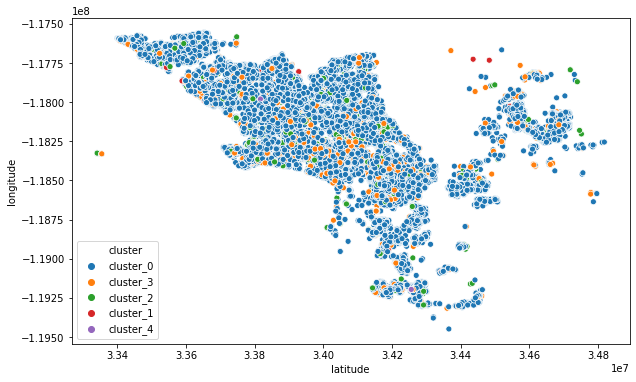

In [47]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X_scaled)
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)
train['cluster'] = 'cluster_' + train.cluster.astype(str)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'latitude', y = 'longitude', data = train, hue = 'cluster')


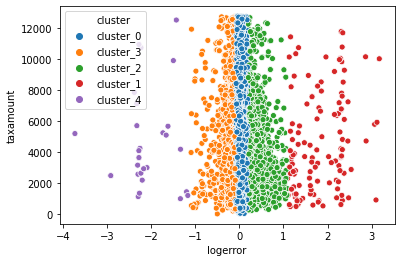

In [48]:
sns.scatterplot(x = 'logerror', y = 'taxamount', data = train, hue = 'cluster')

(89000.0, 98000.0)

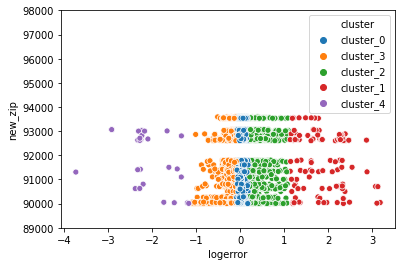

In [49]:
sns.scatterplot(x = 'logerror', y = 'new_zip', data = train, hue = 'cluster')
plt.ylim(89000, 98000)

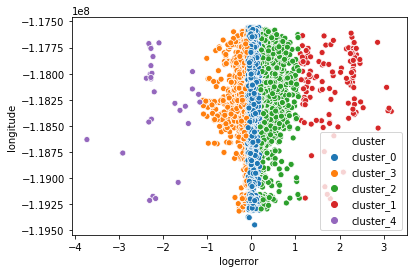

In [50]:
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

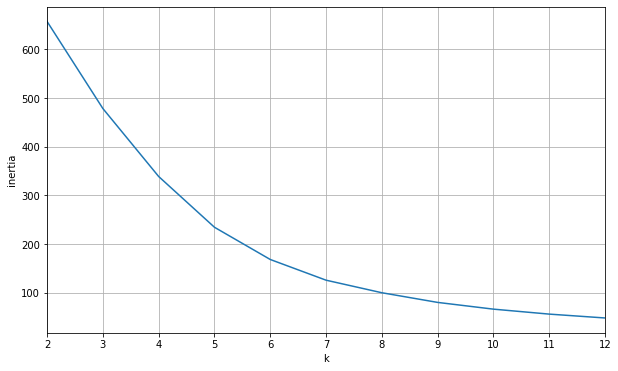

In [10]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

### Cluster Independent Variables

Location, that is, latitude and longitude\
Size (finished square feet)\
Location and size\
Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

In [67]:
train = train.drop(columns = 'cluster')

In [61]:
X = train[['latitude', 'longitude', 'logerror']]

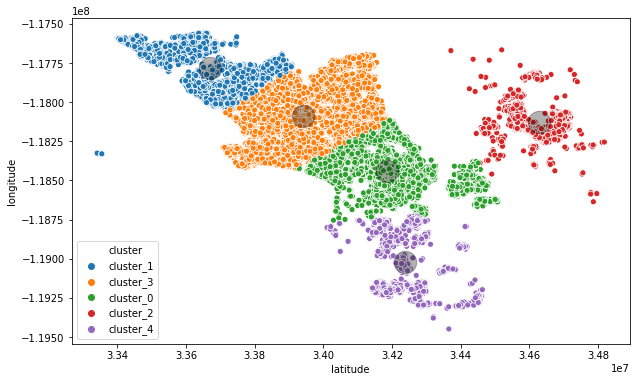

In [62]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

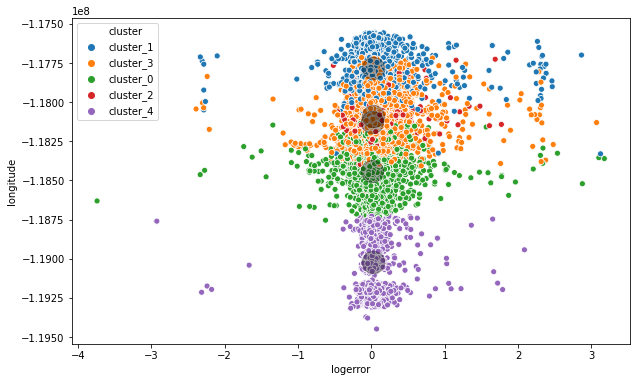

In [64]:
scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)

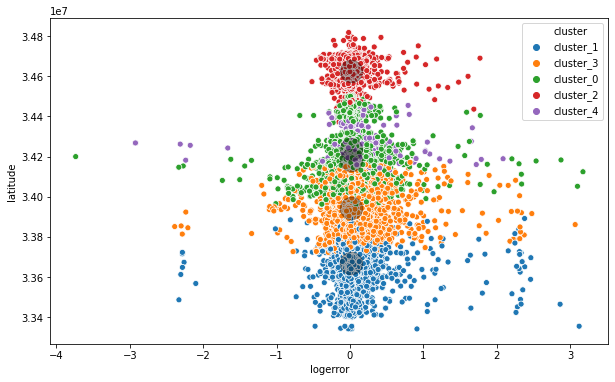

In [65]:
scatter_plot('logerror','latitude',train,kmeans, X_scaled, scaler)

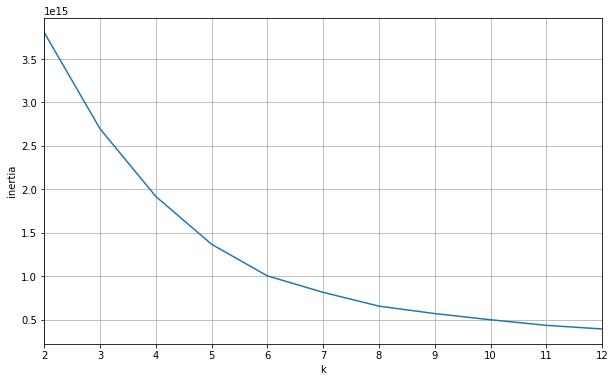

In [66]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [68]:
# lets cluster based on size (sqft)
X = train[['finishedsquarefeet12', 'logerror']]

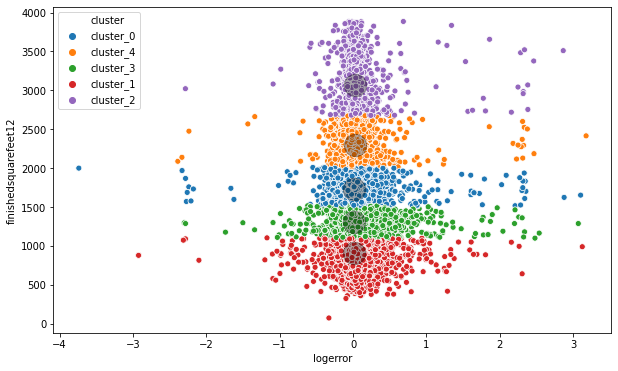

In [69]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)

In [70]:
X = train[['latitude', 'longitude', 'finishedsquarefeet12', 'logerror']]

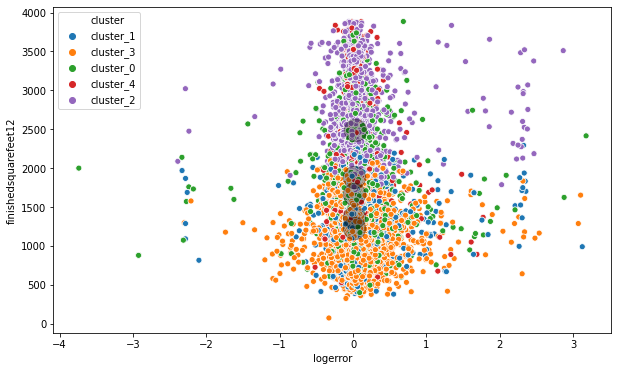

In [71]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)

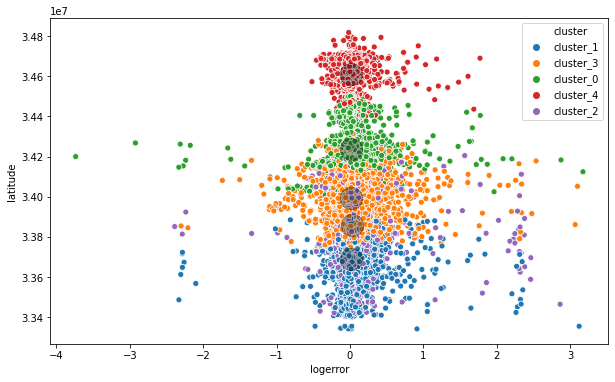

In [73]:
scatter_plot('logerror','latitude',train,kmeans, X_scaled, scaler)

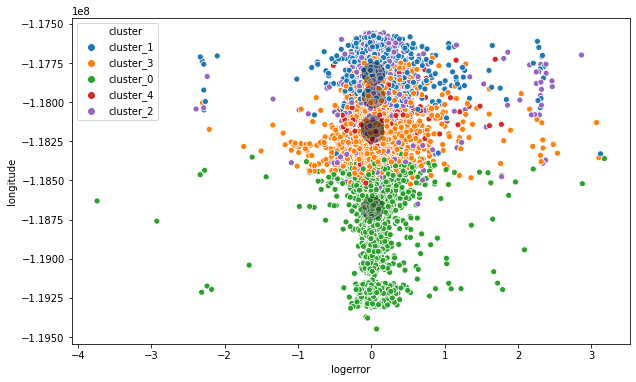

In [74]:
scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)

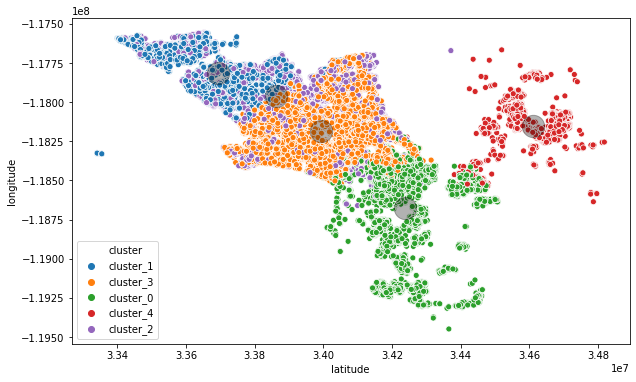

In [75]:
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)